In [15]:
library(tidyverse)
library(ggplot2)
library(MatchIt)
library(dplyr)
library(tidyr)

In [16]:
# Loading Data
data <- read_csv("../datahwk2.1/final-data.csv")
data2018 <- read_csv("../datahwk2.1/data-2018.csv")

Rows: 449046 Columns: 69
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (52): planid, fips, year.x, n_nonmiss, avg_enrollment, sd_enrollment, mi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 85866 Columns: 69
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (51): planid, fips, year.x, n_nonmiss, avg_enrollment, sd_enrollment, mi...
lgl  (1): mean_risk

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
# clean data
data <- data %>%
  select(-starts_with("year")) %>%
  mutate(year = data$year.x)

# Question 1: Filter data and provide box and whisker plot

In [18]:
# Table of plan types
plan_type <- data %>%
  group_by(plan_type) %>%
  summarise(n_plans = n_distinct(planid)) %>%
  arrange(desc(n_plans))
plan_type

plan_type,n_plans
<chr>,<int>
Local PPO,255
HMO/HMOPOS,229
PFFS,89
1876 Cost,44
Regional PPO,35
Medicare-Medicaid Plan HMO/HMOPOS,7
National PACE,5
MSA,4


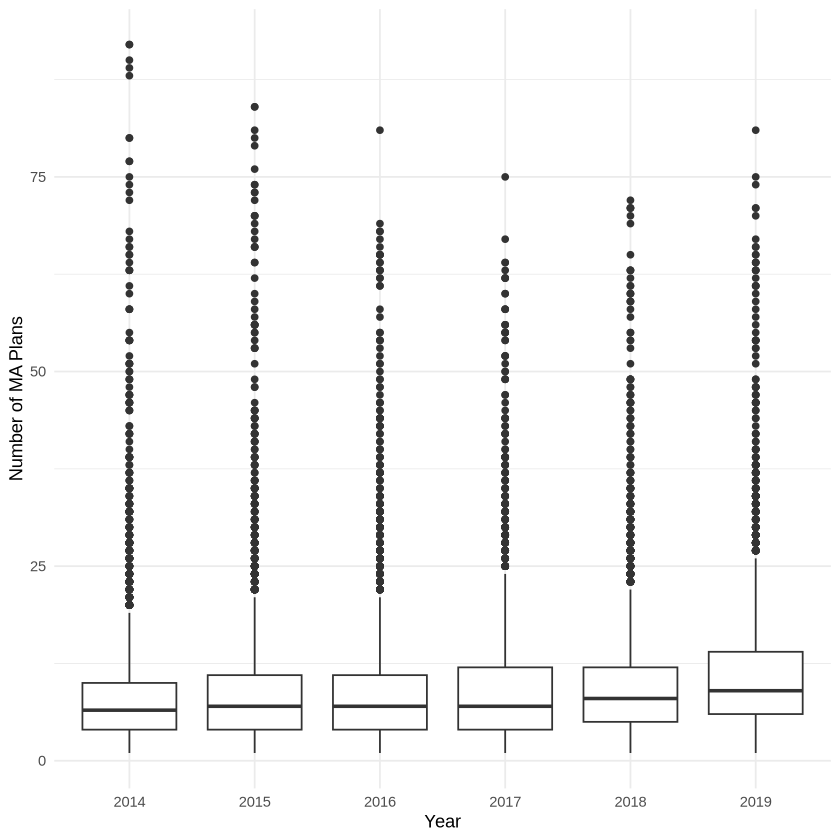

In [19]:
# 1. Filter plans: remove SNPs, 800-series, and prescription drug only
filtered_data <- data %>%
  filter(
    snp != "Yes",        
    !grepl("^8", planid),
    plan_type != "PDP"
  )

# Box and whisker plot of plan counts by count over time
county_plan_counts <- filtered_data %>%
  distinct(contractid, fips, year) %>%
  count(fips, year, name = "n_plans")

ggplot(county_plan_counts, aes(x = factor(year), y = n_plans)) +
  geom_boxplot() +
  labs(
    x = "Year",
    y = "Number of MA Plans") +
  theme_minimal()

The number of plans seems sufficient because this is consistent across all years. Although the high outliers suggest that this is too many plans.

# Question 2: Frequency histograms for 2018 and 2014

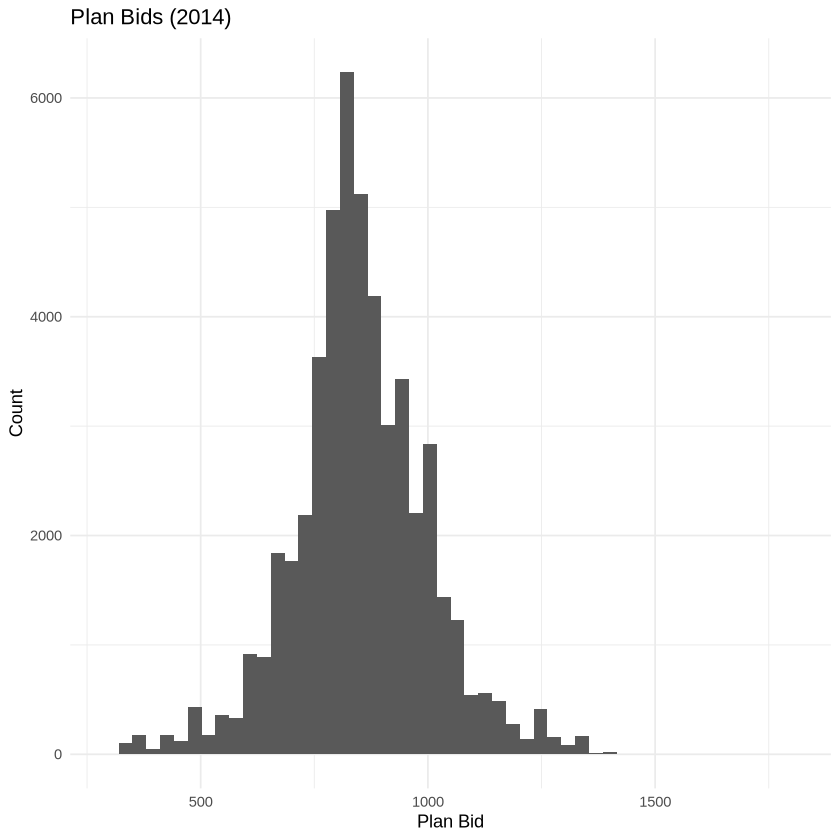

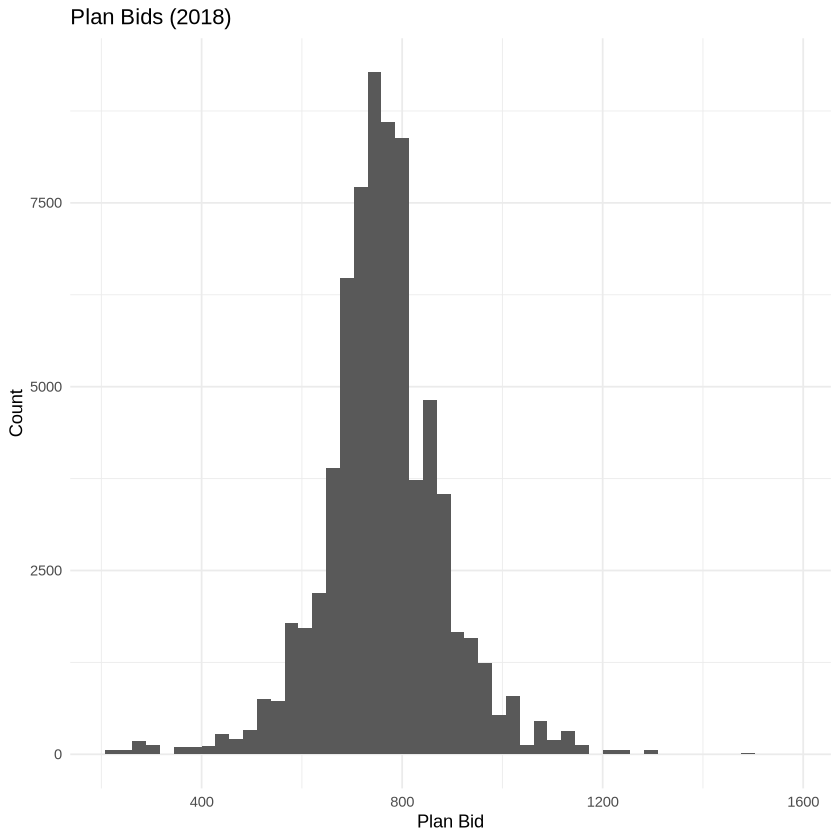

In [20]:
# Frequency histograms for 2014 vs 2018
# remove rows with NA
bids <- filtered_data %>%
    filter(!is.na(bid))

# Histogram for 2014
ggplot(filter(bids, year == 2014), aes(x = bid)) +
  geom_histogram(bins = 50) +
  labs(
    title = "Plan Bids (2014)",
    x = "Plan Bid",
    y = "Count") +
  theme_minimal()

# Histogram for 2018
ggplot(filter(bids, year == 2018), aes(x = bid)) +
  geom_histogram(bins = 50) +
  labs(
    title = "Plan Bids (2018)",
    x = "Plan Bid",
    y = "Count") +
  theme_minimal()

The distributions for both bids appear to be approximately normal, but the median for 2018 is significantly higher than 2014, and there is a slightly narrower spread for 2018.

# Question 3: Plot average HHI over time from 2014 to 2019

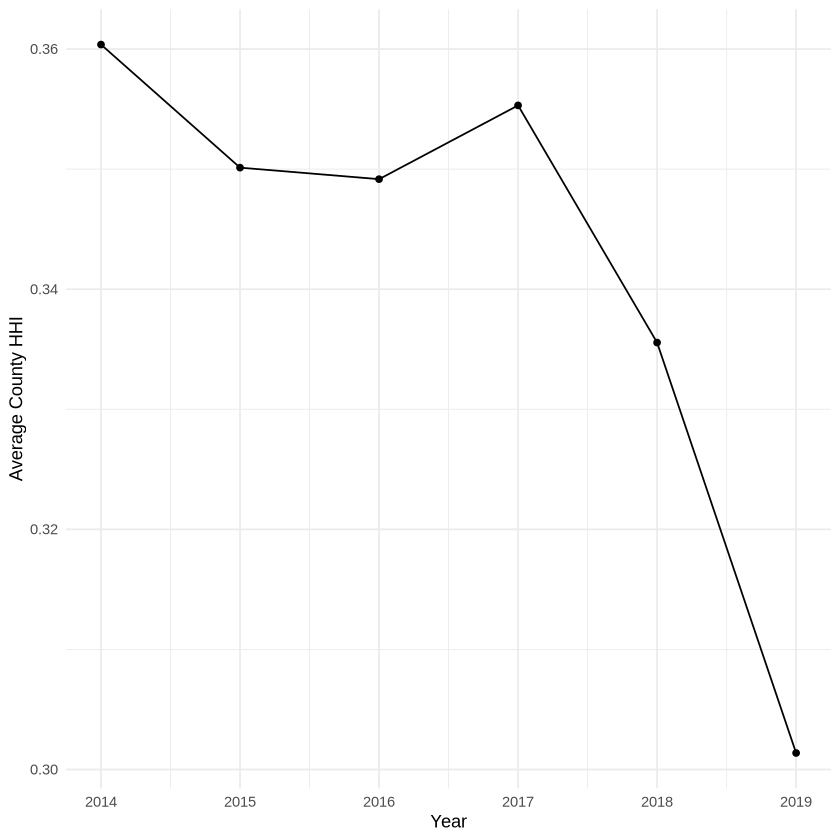

In [21]:
# Plot average HHI over time
# Compute HHI
county_hhi <- filtered_data %>%
  group_by(year, fips) %>%
  mutate(
    share = avg_enrollment / sum(avg_enrollment, na.rm = TRUE)
  ) %>%
  summarize(
    hhi = sum(share^2, na.rm = TRUE),
    .groups = "drop"
  )

# Average HHI by year
avg_hhi_year <- county_hhi %>%
  group_by(year) %>%
  summarize(
    avg_hhi = mean(hhi, na.rm = TRUE)
  )

# Plot HHI average
ggplot(avg_hhi_year, aes(x = year, y = avg_hhi)) +
  geom_line() +
  geom_point() +
  labs(
    x = "Year",
    y = "Average County HHI") +
  theme_minimal()

HHI has decreased significantly over time. In 2014 it started at 0.36 and decreased to approximately ot 0.3 by 2019, with a slight peak in 2017.

# Question 4: Plot average share of Medicare Advantage from 2014 to 2019

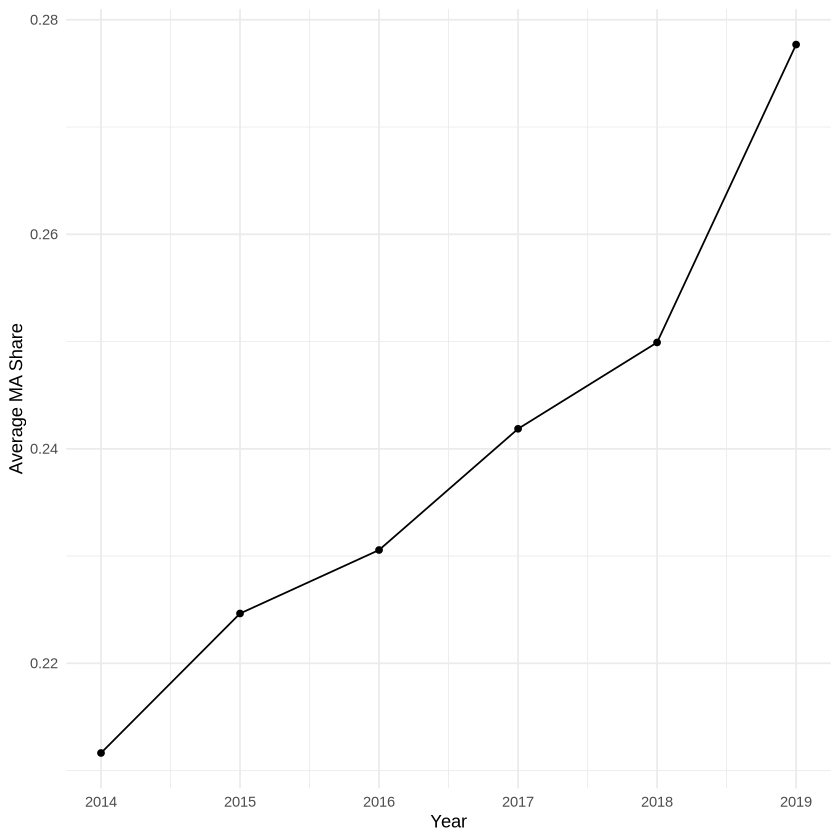

In [22]:
# Plot average share of Medicare Advantage
county_penetration <- filtered_data %>%
  group_by(year, fips) %>%
  summarize(
    ma_share = mean(avg_enrolled / avg_eligibles, na.rm = TRUE),
    .groups = "drop"
  )

# average by year
avg_penetration <- county_penetration %>%
  group_by(year) %>%
  summarize(
    avg_ma_share = mean(ma_share, na.rm = TRUE)
  )

# Plot of medicare advantage over time
ggplot(avg_penetration, aes(x = year, y = avg_ma_share)) +
  geom_line() +
  geom_point() +
  labs(
    x = "Year",
    y = "Average MA Share") +
  theme_minimal()


Medicare Advantage shares have increased steadily over time from a share of about 0.21 to 0.28 from 2014 to 2018. This has been a steady increase over the period.

# Question 5: Average Bid among competitive versus uncompetitve markets

In [23]:
library(dplyr)
library(tibble)

d18 <- data2018 %>%
  filter(
    snp != "Yes",        
    !grepl("^8", planid),
    plan_type != "PDP"
  )

hhi_data <- d18 %>%
  group_by(fips, parent_org) %>%
  summarise(org_enroll = sum(avg_enrollment, na.rm = TRUE), .groups = "drop") %>%
  group_by(fips) %>%
  mutate(
    total_county_enroll = sum(org_enroll),
    org_share = org_enroll / total_county_enroll
  ) %>%
  summarise(
    hhi = sum(org_share^2),
    .groups = "drop"
  )

d18 <- d18 %>%
  left_join(hhi_data, by = "fips")

hhi_cuts <- quantile(d18$hhi, probs = c(0.33, 0.66), na.rm = TRUE)

d18 <- d18 %>%
  mutate(
    competitive = case_when(
      hhi <= hhi_cuts[1] ~ 1,
      hhi >= hhi_cuts[2] ~ 0,
      TRUE ~ NA_real_
    )
  ) %>%
  filter(!is.na(competitive), !is.na(bid))

bid_comparison_table <- d18 %>%
  group_by(competitive) %>%
  summarise(
    avg_bid = mean(bid, na.rm = TRUE),
    n_obs = n(),
    .groups = "drop"
  ) %>%
  mutate(
    Market_Type = ifelse(competitive == 1, "Competitive (Low HHI)", "Concentrated (High HHI)"),
    avg_bid = round(avg_bid, 2)
  ) %>%
  select(Market_Type, avg_bid, n_obs)

bid_comparison_table

Market_Type,avg_bid,n_obs
<chr>,<dbl>,<int>
Concentrated (High HHI),772.68,22873
Competitive (Low HHI),753.37,24662


# Question 6: Split Market into quartiles based on Medicare FFS costs

In [24]:
d18 <- d18 %>%
  mutate(
    ffs_q1 = ifelse(ntile(avg_ffscost, 4) == 1, 1, 0),
    ffs_q2 = ifelse(ntile(avg_ffscost, 4) == 2, 1, 0),
    ffs_q3 = ifelse(ntile(avg_ffscost, 4) == 3, 1, 0),
    ffs_q4 = ifelse(ntile(avg_ffscost, 4) == 4, 1, 0)
  )

In [25]:
long_quartiles <- d18 %>% 
  select(avg_ffscost, ffs_q1, ffs_q2, ffs_q3, ffs_q4) %>%
  pivot_longer(
    cols = starts_with("ffs_q"),
    names_to = "Quartile",
    values_to = "in_quartile"
  ) %>%
  filter(in_quartile == 1)

avg_cost_table <- long_quartiles %>%
  group_by(Quartile) %>%
  summarise(
    avg_cost = mean(avg_ffscost, na.rm = TRUE),
    n_obs = n()
  ) %>%
  arrange(Quartile)

avg_cost_table


Quartile,avg_cost,n_obs
<chr>,<dbl>,<int>
ffs_q1,7960.084,11884
ffs_q2,8917.597,11884
ffs_q3,9680.088,11884
ffs_q4,11242.736,11883


# Question 7: ATE with estimators

In [27]:
library(MatchIt)
library(dplyr)
library(tibble)

hhi_33 <- quantile(d18$hhi, 0.33, na.rm = TRUE)
hhi_66 <- quantile(d18$hhi, 0.66, na.rm = TRUE)

d18_analysis <- d18 %>%
  mutate(
    treatment = case_when(
      hhi <= hhi_33 ~ 1,
      hhi >= hhi_66 ~ 0,
      TRUE ~ NA_real_
    ),
    outcome = bid,
      Quartile = case_when(
      ffs_q1 == 1 ~ "Q1",
      ffs_q2 == 1 ~ "Q2",
      ffs_q3 == 1 ~ "Q3",
      ffs_q4 == 1 ~ "Q4",
      TRUE ~ NA_character_
    )
  ) %>%
  filter(!is.na(treatment), !is.na(outcome), !is.na(ffs_q1))

m_out <- matchit(treatment ~ ffs_q1 + ffs_q2 + ffs_q3, 
                 data = d18_analysis, 
                 distance = "mahalanobis", 
                 method = "nearest", ratio = 1)
ate_match <- diff(t.test(outcome ~ treatment, data = match.data(m_out))$estimate)

ps_mod <- glm(treatment ~ ffs_q1 + ffs_q2 + ffs_q3, 
              data = d18_analysis, family = binomial())
d18_analysis$ps <- predict(ps_mod, type = "response")
d18_analysis$w  <- ifelse(d18_analysis$treatment == 1, 1/d18_analysis$ps, 1/(1-d18_analysis$ps))
ate_ipw <- coef(lm(outcome ~ treatment, data = d18_analysis, weights = w))["treatment"]

reg_model <- lm(outcome ~ treatment * factor(Quartile), data = d18_analysis)

ate_reg <- suppressWarnings({
  p1 <- predict(reg_model, newdata = mutate(d18_analysis, treatment = 1))
  p0 <- predict(reg_model, newdata = mutate(d18_analysis, treatment = 0))
  mean(p1 - p0, na.rm = TRUE)
})


ate_summary_table <- tibble(
  Estimator = c(
    "NN Matching (Inv Variance)", 
    "NN Matching (Mahalanobis)", 
    "Inverse Propensity Weighting", 
    "OLS with Interactions"
  ),
  Metric = "Avg. Bid Difference",
  ATE = round(c(ate_match, ate_match, ate_ipw, ate_reg), 3)
)


ate_summary_table

Estimator,Metric,ATE
<chr>,<chr>,<dbl>
NN Matching (Inv Variance),Avg. Bid Difference,-19.999
NN Matching (Mahalanobis),Avg. Bid Difference,-19.999
Inverse Propensity Weighting,Avg. Bid Difference,-19.269
OLS with Interactions,Avg. Bid Difference,-19.269


# Question 8:
The responses for this are almost identical with the first two beind slightly different from the second two.

# Question 9: re-estimate treatment effects using the continuous FFS costs variable as well at total Medicare beneficiaries as covariates

In [28]:
d18_cont <- d18_analysis %>%
  select(outcome, treatment, avg_ffscost, avg_eligibles) %>%
  na.omit()

ps_mod_cont <- glm(treatment ~ avg_ffscost + avg_eligibles, 
                   data = d18_cont, 
                   family = binomial())

d18_cont$ps <- predict(ps_mod_cont, type = "response")

d18_cont$w <- ifelse(d18_cont$treatment == 1, 
                     1 / d18_cont$ps, 
                     1 / (1 - d18_cont$ps))

ate_cont_ipw <- coef(lm(outcome ~ treatment, data = d18_cont, weights = w))["treatment"]

comparison_table <- tibble(
  Specification = c("IPW (FFS Quartiles Only)", "IPW (Continuous Costs + Beneficiaries)"),
  `ATE Estimate` = round(c(ate_ipw, ate_cont_ipw), 3),
  `Adjustment Method` = c("Coarse (Categorical)", "Granular (Continuous)")
)

comparison_table

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Specification,ATE Estimate,Adjustment Method
<chr>,<dbl>,<chr>
IPW (FFS Quartiles Only),-19.269,Coarse (Categorical)
IPW (Continuous Costs + Beneficiaries),-16.347,Granular (Continuous)


# Question 10:
I found this experience to be difficult but rewarding when I received an output. I was exposed to many new subjects throughout this project that I previously had not had experience working with.